In [1]:
from utilities import *
from sklearn.metrics import mean_squared_error

In [2]:
# x-space
FOV = 256 # length of the object
N = 256 # sampling points in x-space, k-space, and time space (ADC on)

delta_x = FOV / N # sampling interval in x-space
x_axis = np.linspace(-FOV / 2, FOV / 2 - delta_x, N)

# k-space
delta_k = 1 / FOV # sampling interval in k-space
FOV_k = delta_k * N # length of the k-space
k_axis = np.linspace(-FOV_k / 2, FOV_k / 2 - delta_k, N)

# gradient
Gx = 4.7e-6 # gradient T/mm
gamma = 2.68e8 # rad/s/T
gamma_bar = 0.5 * gamma/np.pi # s^-1T^-1

# time space
gamma_bar_Gx = gamma_bar * Gx * 1e-3

delta_t = delta_k / gamma_bar_Gx # ms sampling interval in time space
tau = np.abs((-FOV_k * 0.5) / gamma_bar_Gx) # ms dephasing time

t_max = 3 * tau - delta_t # rephasing process is 2 times longer than dephasing process
t_axis = np.linspace(0, t_max, int(N * 1.5))


(128,)


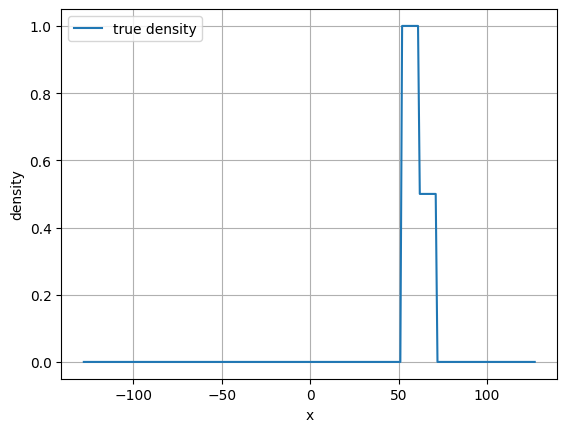

In [231]:
density = np.zeros(len(x_axis))
density[180:190] = 1
density[190:200] = 0.5

plt.plot(x_axis, density, '-', label='true density')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.grid()

# create spins after the rf pulse (lying on the y-axis)
# assume the spins are lying on each sampling point over y-axis
m0 = 1.0
vec_spins = np.zeros((3, N))
vec_spins[1, :] = 1

# dephasing
# Gx on between t1 and t2 (T_s / 2)
w_G = w_grad(w_0=0, G_value=Gx, gamma=gamma * 1e-3, pos=x_axis, dim=1)
G_traj_1 = np.ones((int(N/2), 1)) * Gx
res_1 = multiple_FID(vec_spins, m0, 0, w_G, 1, 1e10, tau, int(N/2), 'z')

store = []
for i in range(2):
    tmp = res_1[i,:,:].squeeze() # shape: (number of steps, number of sampling points)
    
    store.append(tmp @ density) # multiply by true density
print(store[0].shape)
real_part_1, imag_part_1 = store[1], store[0]

# rephasing

# -Gx on between t2 and t3 (T_s)
w_G = w_grad(w_0=0, G_value=-Gx, gamma=gamma * 1e-3, pos=x_axis, dim=1)
G_traj_2 = np.ones((N, 1)) * -Gx
res_2 = multiple_FID(res_1[:,-1,:], m0, 0, w_G, 1, 1e10, tau*2, N, 'z')

store = []
for i in range(2):
    tmp = res_2[i,:,:].squeeze()
    store.append(tmp @ density)

real_part_2, imag_part_2 = store[1], store[0]

Text(0, 0.5, 'Gx (mT/m)')

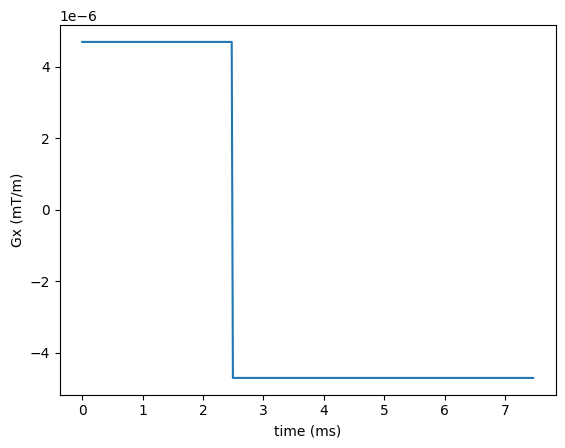

In [232]:
G_traj = np.concatenate((G_traj_1, G_traj_2), axis=0)
plt.plot(t_axis, G_traj, label='Gx')
plt.xlabel('time (ms)')
plt.ylabel('Gx (mT/m)')

Text(0, 0.5, 'k-space (1/m)')

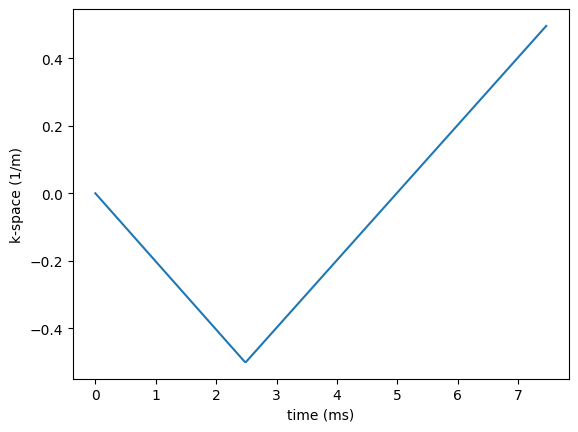

In [233]:
k_traj_1 = np.linspace(0, -FOV_k / 2, int(N/2))
k_traj_2 = k_axis

k_traj = np.concatenate((k_traj_1, k_traj_2), axis=0)
plt.plot(t_axis, k_traj)
plt.xlabel('time (ms)')
plt.ylabel('k-space (1/m)')

Text(0, 0.5, 'signal')

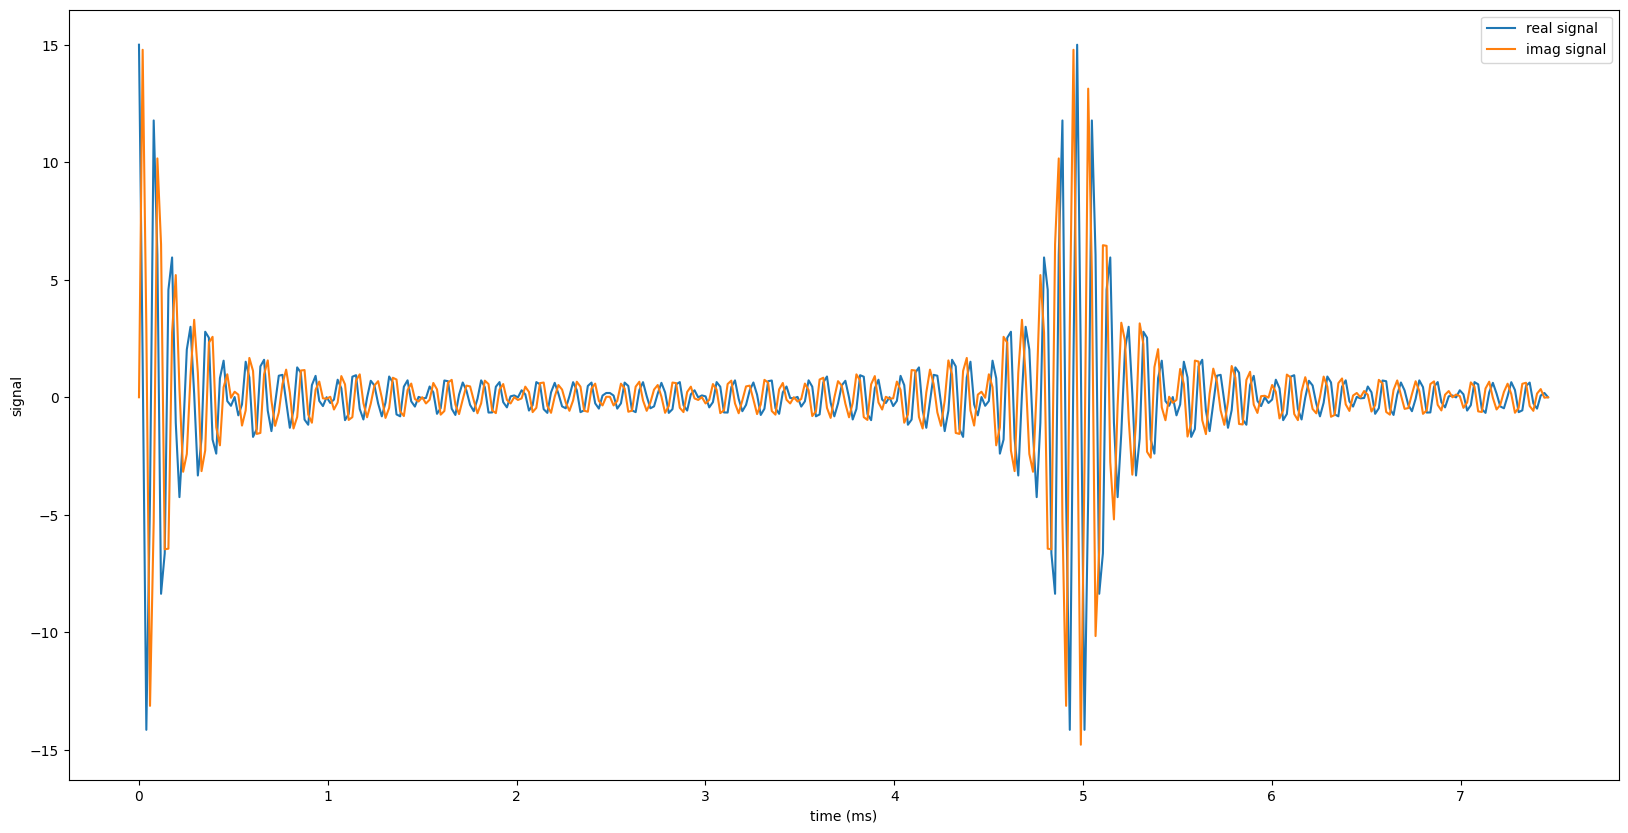

In [234]:
signal_real = np.concatenate((real_part_1, real_part_2), axis=0)
signal_imag = np.concatenate((imag_part_1, imag_part_2), axis=0)
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(t_axis, signal_real, label='real signal')
plt.plot(t_axis, signal_imag, label='imag signal')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('signal')

Text(0, 0.5, 'reconstructed density')

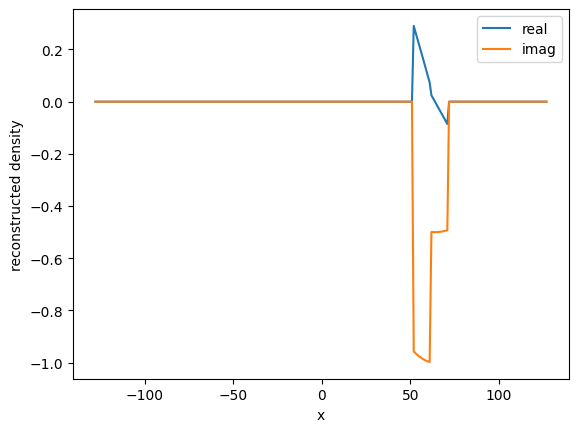

In [235]:
adc_signal = real_part_2 * 1 + 1j * imag_part_2

re_density = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(adc_signal)))
plt.plot(x_axis, np.real(re_density), label='real')
plt.plot(x_axis, np.imag(re_density), label='imag')
plt.legend()
plt.xlabel('x')
plt.ylabel('reconstructed density')

Text(0, 0.5, 'density')

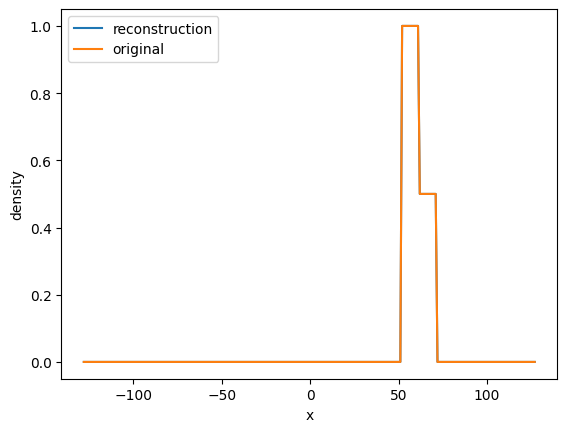

In [236]:
plt.plot(x_axis, np.abs(re_density), label='reconstruction')
plt.plot(x_axis, density, label='original')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')